In [1]:
import random
import pandas as pd
import numpy as np

import plotly
import plotly.graph_objects as go
import plotly.express as px

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler, RobustScaler

from plot_func import plot_classification_report,plot_roc,plot_confusion_matrix

import plotly.express as px

from tqdm import tqdm

In [69]:
pd.read_csv('../Health_Insurance_Cross_Sell_Prediction.csv').shape

(381109, 12)

In [28]:
# Reading data
original_data = pd.read_csv('../Health_Insurance_Cross_Sell_Prediction.csv')
original_data = original_data[0:int(len(original_data)/40)]

In [29]:
original_data.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


In [30]:
columns = original_data.columns

In [31]:
columns

Index(['id', 'Gender', 'Age', 'Driving_License', 'Region_Code',
       'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage', 'Annual_Premium',
       'Policy_Sales_Channel', 'Vintage', 'Response'],
      dtype='object')

In [32]:
train,test = train_test_split(original_data,test_size=0.25,random_state=0)

### Data Preprocessing



In [33]:
num_feat = ['Age','Vintage']
cat_feat = ['Gender', 'Driving_License', 'Previously_Insured', 'Vehicle_Age_lt_1_Year','Vehicle_Age_gt_2_Years','Vehicle_Damage_Yes','Region_Code','Policy_Sales_Channel']


In [34]:
train['Gender'] = train['Gender'].map( {'Female': 0, 'Male': 1} ).astype(int)
train=pd.get_dummies(train,drop_first=True)
train=train.rename(columns={"Vehicle_Age_< 1 Year": "Vehicle_Age_lt_1_Year", "Vehicle_Age_> 2 Years": "Vehicle_Age_gt_2_Years"})
train['Vehicle_Age_lt_1_Year']=train['Vehicle_Age_lt_1_Year'].astype('int')
train['Vehicle_Age_gt_2_Years']=train['Vehicle_Age_gt_2_Years'].astype('int')
train['Vehicle_Damage_Yes']=train['Vehicle_Damage_Yes'].astype('int')


ss = StandardScaler()
train[num_feat] = ss.fit_transform(train[num_feat])

mm = MinMaxScaler()
train[['Annual_Premium']] = mm.fit_transform(train[['Annual_Premium']])

train=train.drop('id',axis=1)

for column in cat_feat:
    train[column] = train[column].astype('str')

In [35]:
from imblearn.over_sampling import SMOTE
# Resampling the minority class. The strategy can be changed as required.
sm = SMOTE(sampling_strategy='minority', random_state=42)
# Fit the model to generate the data.
oversampled_X, oversampled_Y = sm.fit_resample(train.drop('Response', axis=1), train['Response'])
train = pd.concat([pd.DataFrame(oversampled_Y), pd.DataFrame(oversampled_X)], axis=1)

In [36]:
test['Gender'] = test['Gender'].map( {'Female': 0, 'Male': 1} ).astype(int)
test=pd.get_dummies(test,drop_first=True)
test=test.rename(columns={"Vehicle_Age_< 1 Year": "Vehicle_Age_lt_1_Year", "Vehicle_Age_> 2 Years": "Vehicle_Age_gt_2_Years"})
test['Vehicle_Age_lt_1_Year']=test['Vehicle_Age_lt_1_Year'].astype('int')
test['Vehicle_Age_gt_2_Years']=test['Vehicle_Age_gt_2_Years'].astype('int')
test['Vehicle_Damage_Yes']=test['Vehicle_Damage_Yes'].astype('int')
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler, RobustScaler
ss = StandardScaler()
test[num_feat] = ss.fit_transform(test[num_feat])


mm = MinMaxScaler()
test[['Annual_Premium']] = mm.fit_transform(test[['Annual_Premium']])
for column in cat_feat:
    test[column] = test[column].astype('str')


In [37]:
from imblearn.over_sampling import SMOTE
# Resampling the minority class. The strategy can be changed as required.
sm = SMOTE(sampling_strategy='minority', random_state=42)
# Fit the model to generate the data.
oversampled_X, oversampled_Y = sm.fit_resample(test.drop('Response', axis=1), test['Response'])
test = pd.concat([pd.DataFrame(oversampled_Y), pd.DataFrame(oversampled_X)], axis=1)

In [38]:
from sklearn.model_selection import train_test_split

train_ = train
train_target=train['Response']
train=train.drop(['Response'], axis = 1)
x_train,x_test,y_train,y_test = train_test_split(train,train_target, random_state = 0)


### Data Modelling and Evaluation

In [39]:
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
import xgboost as xgb


from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold, KFold, GridSearchCV


# import packages for hyperparameters tuning
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

from scipy.stats import randint

from sklearn.metrics import (f1_score, roc_auc_score,accuracy_score,confusion_matrix,
                             precision_recall_curve, auc, roc_curve, recall_score,classification_report)
from sklearn.metrics import accuracy_score


import pickle


In [40]:
def run_RandomizedSearchCV(model,random_search,x_train,y_train):
    model_ = RandomizedSearchCV(estimator = model,
                                param_distributions = random_search,
                                n_iter = 10,
                                cv = 4,
                                verbose= 1,
                                random_state= 101,
                                n_jobs = -1)
    model_.fit(x_train,y_train)    
    return model_

In [41]:
random_search = {'criterion': ['entropy', 'gini'],
               'max_depth': [2,3,4,5,6,7,10],
               'min_samples_leaf': [4, 6, 8],
               'min_samples_split': [5, 7,10],
               'n_estimators': [300]}

clf = RandomForestClassifier()



In [42]:
model = run_RandomizedSearchCV(clf,random_search,x_train,y_train)

Fitting 4 folds for each of 10 candidates, totalling 40 fits


In [43]:
filename = 'rf_model.sav'
pickle.dump(model, open(filename, 'wb'))
rf_load = pickle.load(open(filename, 'rb'))

In [44]:
y_pred=model.predict(x_test)

In [45]:
print(classification_report(y_test, y_pred,zero_division=0))

              precision    recall  f1-score   support

           0       0.93      0.76      0.84      1525
           1       0.80      0.95      0.87      1588

    accuracy                           0.86      3113
   macro avg       0.87      0.85      0.85      3113
weighted avg       0.87      0.86      0.85      3113



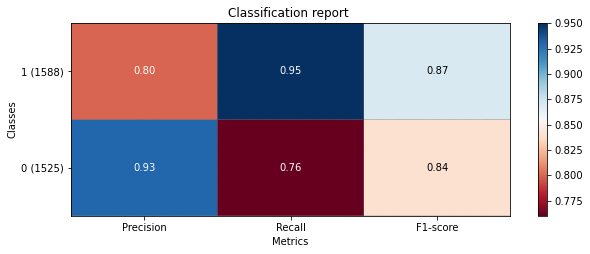

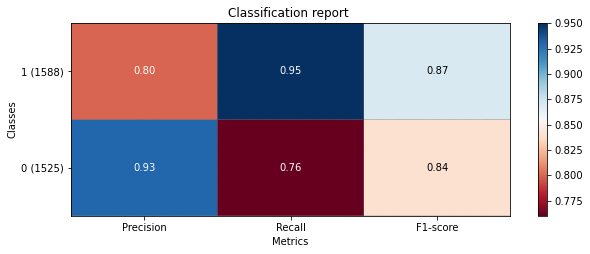

In [46]:
sampleClassificationReport = classification_report(y_test, y_pred,zero_division=0)
plot_classification_report(sampleClassificationReport)

In [47]:
plot_roc(model,x_test,y_test)

In [48]:
confusion_matrix(y_test,y_pred)

array([[1160,  365],
       [  83, 1505]])

In [49]:
plot_confusion_matrix(y_test,y_pred)

In [50]:
names = [
    "Nearest Neighbors",
    "SVC",
    "Decision Tree",
    "Random Forest",
    "Neural Net",
    "AdaBoost",
    "Naive Bayes",
    "QDA"
]

classifiers = [
    KNeighborsClassifier(),
    SVC(),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    MLPClassifier(),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis()
]

random_search_dict = {
    "Nearest Neighbors":{
        'n_neighbors':[4,5,6,7,8],
        'weights':['uniform', 'distance'],
        'algorithm':['auto', 'ball_tree', 'kd_tree', 'brute'],
        'leaf_size':[20,30,40],
        'p':[2,3],
        'metric':['minkowski'],
        'n_jobs':[-1],
    },
    "SVC":{
        'C':[1.0,2.0],
        'kernel':['poly','rbf'],
        'degree':[2,3,4],
        'gamma':['scale'],
        'probability':[True]        
    },
    "Decision Tree":{
        'max_depth':[5,6,7],
        'criterion' : ["gini", "entropy", "log_loss"],
        'splitter': ["best", "random"]
    },
    "Random Forest":{
        'criterion': ['entropy', 'gini'],
        'max_depth': [2,3,4,5,6,7,10],
        'min_samples_leaf': [4, 6, 8],
        'min_samples_split': [5, 7,10],
        'n_estimators': [300]
    },
    "Neural Net":{
        'hidden_layer_sizes':[(500,),(1000,)],
        'activation':['logistic', 'tanh', 'relu'],
        'solver':['sgd','adam'],
        'alpha':[0.0001,0.001]        
    },
    "AdaBoost":{
        'n_estimators':[50,100],
        'learning_rate':[1.0,2.0],
        'algorithm':['SAMME', 'SAMME.R'],

    },
    "Naive Bayes":{
        'var_smoothing':[1e-9,1e-10]
    },
    "QDA":{
        'reg_param':[0.0,0.0001,0.1]
    }
    
}


In [51]:
random_search_dict

{'Nearest Neighbors': {'n_neighbors': [4, 5, 6, 7, 8],
  'weights': ['uniform', 'distance'],
  'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
  'leaf_size': [20, 30, 40],
  'p': [2, 3],
  'metric': ['minkowski'],
  'n_jobs': [-1]},
 'SVC': {'C': [1.0, 2.0],
  'kernel': ['poly', 'rbf'],
  'degree': [2, 3, 4],
  'gamma': ['scale'],
  'probability': [True]},
 'Decision Tree': {'max_depth': [5, 6, 7],
  'criterion': ['gini', 'entropy', 'log_loss'],
  'splitter': ['best', 'random']},
 'Random Forest': {'criterion': ['entropy', 'gini'],
  'max_depth': [2, 3, 4, 5, 6, 7, 10],
  'min_samples_leaf': [4, 6, 8],
  'min_samples_split': [5, 7, 10],
  'n_estimators': [300]},
 'Neural Net': {'hidden_layer_sizes': [(500,), (1000,)],
  'activation': ['logistic', 'tanh', 'relu'],
  'solver': ['sgd', 'adam'],
  'alpha': [0.0001, 0.001]},
 'AdaBoost': {'n_estimators': [50, 100],
  'learning_rate': [1.0, 2.0],
  'algorithm': ['SAMME', 'SAMME.R']},
 'Naive Bayes': {'var_smoothing': [1e-09, 1e-10]},

In [52]:
final_dict = {}

0it [00:00, ?it/s]

For model: Nearest Neighbors
Fitting 4 folds for each of 10 candidates, totalling 40 fits


1it [00:03,  3.68s/it]

For model: SVC
Fitting 4 folds for each of 10 candidates, totalling 40 fits


2it [01:50, 64.50s/it]

For model: Decision Tree
Fitting 4 folds for each of 10 candidates, totalling 40 fits


3it [01:51, 35.19s/it]

For model: Random Forest
Fitting 4 folds for each of 10 candidates, totalling 40 fits


4it [02:01, 25.31s/it]

For model: Neural Net
Fitting 4 folds for each of 10 candidates, totalling 40 fits


/Users/vineethchennuru/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/vineethchennuru/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/vineethchennuru/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
5it [02:57, 36.63s/it]/Users/vineethchennuru/.local/lib/python3.9/site-packages/sklearn/model_selection/_search.py:306: UserWarning:

The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.



For model: AdaBoost
Fitting 4 folds for each of 8 candidates, totalling 32 fits


6it [03:02, 25.86s/it]/Users/vineethchennuru/.local/lib/python3.9/site-packages/sklearn/model_selection/_search.py:306: UserWarning:

The total space of parameters 2 is smaller than n_iter=10. Running 2 iterations. For exhaustive searches, use GridSearchCV.

7it [03:03, 17.44s/it]/Users/vineethchennuru/.local/lib/python3.9/site-packages/sklearn/model_selection/_search.py:306: UserWarning:

The total space of parameters 3 is smaller than n_iter=10. Running 3 iterations. For exhaustive searches, use GridSearchCV.

/Users/vineethchennuru/.local/lib/python3.9/site-packages/sklearn/discriminant_analysis.py:887: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/vineethchennuru/.local/lib/python3.9/site-packages/sklearn/discriminant_analysis.py:887: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Users/vineethchennuru/.local/lib/python3.9/site-packages/sklearn/discriminant_analysis.py:887: UserWarning: Variables are colline

For model: Naive Bayes
Fitting 4 folds for each of 2 candidates, totalling 8 fits
For model: QDA
Fitting 4 folds for each of 3 candidates, totalling 12 fits


/Users/vineethchennuru/.local/lib/python3.9/site-packages/sklearn/discriminant_analysis.py:887: UserWarning:

Variables are collinear

8it [03:03, 22.90s/it]


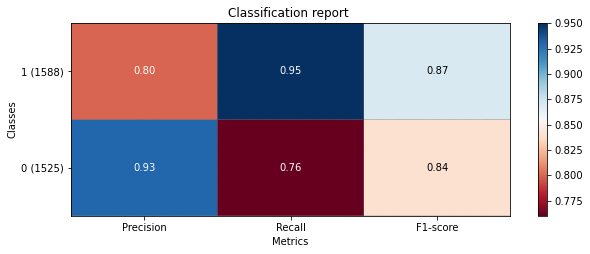

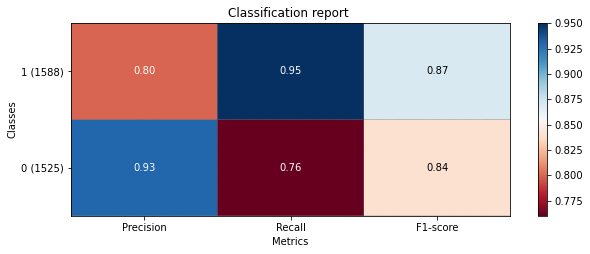

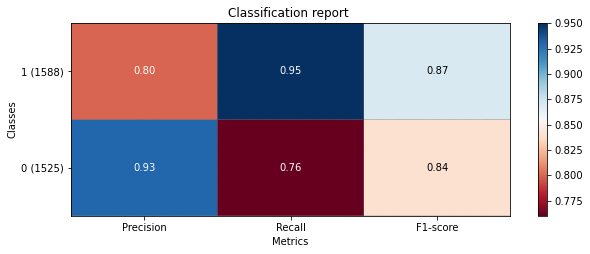

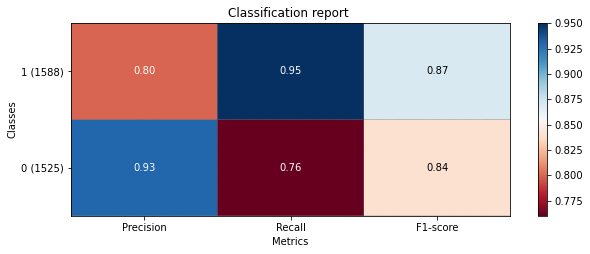

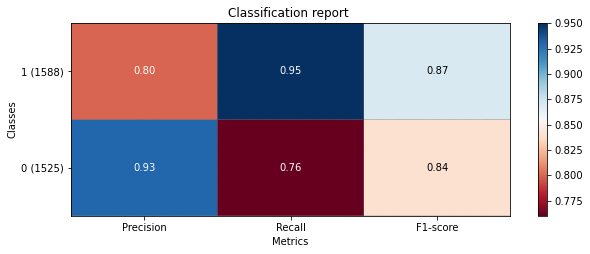

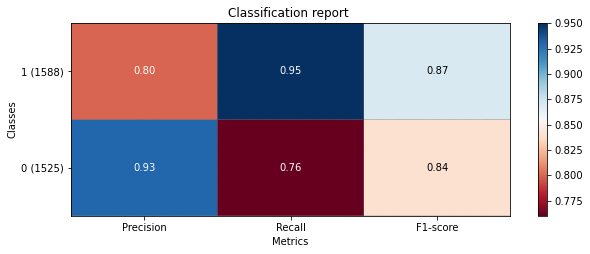

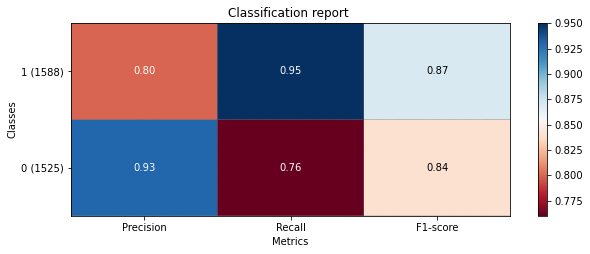

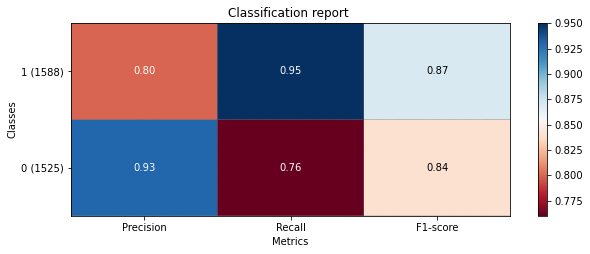

In [53]:
for clf,name in tqdm(zip(classifiers,names)):
    print('For model:',name)
    model = run_RandomizedSearchCV(clf,random_search_dict[name],x_train,y_train)

    filename = 'models/'+name+'_model.sav'
    pickle.dump(model, open(filename, 'wb'))
    rf_load = pickle.load(open(filename, 'rb'))

    y_test_pred=model.predict(x_test)

    final_dict[name] = {}
    final_dict[name]['ClassificationReport']= classification_report(y_test, y_test_pred,zero_division=0)
    final_dict[name]['plot_classification_report'] = plot_classification_report(sampleClassificationReport)
    final_dict[name]['plot_roc'] = plot_roc(model,x_test,y_test)
    final_dict[name]['plot_confusion_matrix_test'] = plot_confusion_matrix(y_test,y_test_pred)

In [54]:
len(x_train.columns)

11

In [55]:
final_dict['Decision Tree'].keys()

dict_keys(['ClassificationReport', 'plot_classification_report', 'plot_roc', 'plot_confusion_matrix_test'])

In [56]:
# for i in final_dict.keys():
#     print(final_dict[i]['ClassificationReport'])
#     display(final_dict[i]['plot_classification_report'])
#     display(final_dict[i]['plot_roc'])
#     display(final_dict[i]['plot_confusion_matrix_test'])

### XGBoost Classifier

In [146]:
cat_feat

['Gender',
 'Driving_License',
 'Previously_Insured',
 'Vehicle_Age_lt_1_Year',
 'Vehicle_Age_gt_2_Years',
 'Vehicle_Damage_Yes',
 'Region_Code',
 'Policy_Sales_Channel']

In [147]:
x_train

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Annual_Premium,Policy_Sales_Channel,Vintage,Vehicle_Age_lt_1_Year,Vehicle_Age_gt_2_Years,Vehicle_Damage_Yes
113669,0,2.204920,1,28.0,0,0.068360,26.0,0.044917,0,1,1
333556,1,0.399075,1,18.0,0,0.053025,124.0,-1.125892,0,0,1
81169,0,-0.439352,1,12.0,1,0.042440,152.0,0.976785,1,0,0
260842,0,-0.955308,1,41.0,1,0.097648,152.0,-0.791375,1,0,0
22009,1,-0.568341,1,28.0,0,0.042129,124.0,-1.591827,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
367804,1,1.624470,1,28.0,0,0.000000,156.0,0.642269,0,0,1
303606,1,0.141098,1,25.0,1,0.036106,124.0,-1.042263,0,0,1
310643,1,-0.439352,1,46.0,0,0.040671,26.0,1.155991,0,0,1
314710,1,-1.084297,1,6.0,0,0.068405,152.0,-1.603774,1,0,1


In [148]:
for column in cat_feat:
    print(column)
    x_train[column] = x_train[column].astype('float').astype('int')
    x_test[column] = x_test[column].astype('float').astype('int')


Gender
Driving_License
Previously_Insured
Vehicle_Age_lt_1_Year
Vehicle_Age_gt_2_Years
Vehicle_Damage_Yes
Region_Code
Policy_Sales_Channel


In [149]:
space={ 'max_depth': hp.quniform("max_depth", 3,18,1),
        'gamma': hp.uniform ('gamma', 1,9),
        'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
        'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'n_estimators': 300,
        'seed': 0
      }


In [150]:
def objective(space):
    evaluation = [( x_train, y_train), ( x_test, y_test)]
    
    clf=xgb.XGBClassifier(
        n_estimators =space['n_estimators'],
        max_depth = int(space['max_depth']),
        gamma = space['gamma'],
        reg_alpha = int(space['reg_alpha']),
        min_child_weight=int(space['min_child_weight']),
        colsample_bytree=int(space['colsample_bytree']),
        eval_metric="auc",
        early_stopping_rounds=10,
    )
    
    
    clf.fit(x_train, y_train,
            eval_set=evaluation,
            verbose=False)
    

    pred = clf.predict(x_test)
    y_score = model.predict_proba(x_test)[:,1]
    accuracy = accuracy_score(y_test, pred>0.5)
    Roc_Auc_Score = roc_auc_score(y_test, y_score)
    print ("ROC-AUC Score:",Roc_Auc_Score)
    print ("SCORE:", accuracy)
    return {'loss': -Roc_Auc_Score, 'status': STATUS_OK }


In [151]:
# from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
trials = Trials()
best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 100,
                        trials = trials)


ROC-AUC Score:                                                                  
0.8380428609122663                                                              
SCORE:                                                                          
0.8776624030899269                                                              
ROC-AUC Score:                                                                  
0.8380428609122663                                                              
SCORE:                                                                          
0.8776624030899269                                                              
ROC-AUC Score:                                                                  
0.8380428609122663                                                              
SCORE:                                                                          
0.8776484088555515                                                              
ROC-AUC Score:              

SCORE:                                                                          
0.8776484088555515                                                              
ROC-AUC Score:                                                                  
0.8380428609122663                                                              
SCORE:                                                                          
0.8776624030899269                                                              
ROC-AUC Score:                                                                  
0.8380428609122663                                                              
SCORE:                                                                          
0.8776624030899269                                                              
ROC-AUC Score:                                                                  
0.8380428609122663                                                              
SCORE:                      

In [152]:
print("The best hyperparameters are : ","\n")
print(best_hyperparams)


The best hyperparameters are :  

{'colsample_bytree': 0.6202922774821162, 'gamma': 7.772712367469275, 'max_depth': 15.0, 'min_child_weight': 4.0, 'reg_alpha': 104.0, 'reg_lambda': 0.4893934851440854}


In [153]:
for key in best_hyperparams.keys():
    if key in ['max_depth','min_child_weight','reg_alpha']:
        best_hyperparams[key] = int(best_hyperparams[key])

In [154]:
xgb_model=xgb.XGBClassifier(n_estimators = space['n_estimators'], **best_hyperparams)

In [155]:
xgb_model.fit(x_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1,
              colsample_bytree=0.6202922774821162, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=7.772712367469275, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_threshold=64,
              max_cat_to_onehot=4, max_delta_step=0, max_depth=15, max_leaves=0,
              min_child_weight=4, missing=nan, monotone_constraints='()',
              n_estimators=300, n_jobs=0, num_parallel_tree=1, predictor='auto',
              random_state=0, ...)

In [156]:
filename = 'models/XG Boost_model.sav'
pickle.dump(xgb_model, open(filename, 'wb'))


In [157]:
plot_roc(xgb_model,x_test,y_test)

In [164]:
y_test.value_counts()

0    62716
1     8742
Name: Response, dtype: int64

In [166]:
confusion_matrix(xgb_model.predict(x_train),y_train)

array([[188080,  26293],
       [     0,      0]])

### CatBoost

In [116]:
cat_model = CatBoostClassifier()
cat_model = cat_model.fit(x_train, y_train, cat_features = cat_feat, eval_set = (x_test, y_test), early_stopping_rounds = 10, verbose = 100)

Learning rate set to 0.056931
0:	learn: 0.6113119	test: 0.6114137	best: 0.6114137 (0)	total: 78.7ms	remaining: 1m 18s
Stopped by overfitting detector  (10 iterations wait)

bestTest = 0.2689659369
bestIteration = 79

Shrink model to first 80 iterations.


In [34]:
predictions = [pred[1] for pred in cat_model.predict_proba(x_test)]
print('Validation ROC AUC Score:', roc_auc_score(y_test, predictions, average = 'weighted'))


Validation ROC AUC Score: 0.85631075201639


In [35]:
plot_roc(cat_model,x_test,y_test)

In [57]:
X = train_.drop(['Response'], axis=1)
y = train_['Response']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=666)

In [58]:
# import matplotlib.pyplot as plt
# import seaborn as sns
# def plot_confusion_matrix(y_real, y_pred):
#     cm = confusion_matrix(y_real, y_pred)

#     ax= plt.subplot()
#     sns.heatmap(cm, annot=True, ax = ax, fmt='g')

#     ax.set_xlabel('Predicted labels')
#     ax.set_ylabel('True labels')
# plot_confusion_matrix(y_test, preds)

In [59]:
X_train = X_train.drop(['Region_Code', 'Vintage', 'Driving_License'], axis=1)
X_test = X_test.drop(['Region_Code', 'Vintage', 'Driving_License'], axis=1)

In [60]:
X_train

,Gender,Age,Previously_Insured,Annual_Premium,Policy_Sales_Channel,Vehicle_Age_lt_1_Year,Vehicle_Age_gt_2_Years,Vehicle_Damage_Yes
4797,1,-0.954821,0,0.112914,152,1,0,0
7785,0,0.317398,0,0.168052,26,0,0.741208,1
10177,0,0.005302,0,0.000881,162.984,0.00534899,0,1
1880,0,1.751863,1,0.134441,124,0,0,0
11398,1,0.500058,0,0.136427,26,0,1,1
...,...,...,...,...,...,...,...,...
2878,1,-1.148156,1,0.123172,152,1,0,0
10142,1,0.547498,0,0.000000,124,0,0,1
7597,1,1.338238,0,0.179789,26,0,0,1
10114,0,-0.176768,0,0.000000,157,0,0,1


In [61]:
cate_ = ['Vehicle_Age_lt_1_Year','Vehicle_Age_gt_2_Years','Vehicle_Damage_Yes',
         'Policy_Sales_Channel','Previously_Insured','Gender']

for col in cate_:
    X_train[col] = X_train[col].astype('float').astype('int')
    X_test[col] = X_test[col].astype('float').astype('int')    

In [62]:
from xgboost import XGBClassifier

In [63]:
xgb_params = {
    'max_depth': 4, 
    'n_estimators': 372, 
    'learning_rate': 0.09345905554110154, 
    'gamma': 0.6641238000625036, 
    'scale_pos_weight': 4
}
xgb_params['random_state'] = 0
xgb = XGBClassifier(**xgb_params)
xgb.fit(X_train, y_train)
preds = xgb.predict(X_test)
print('Optimized XGBClassifier accuracy: ', accuracy_score(y_test, preds))
print('Optimized XGBClassifier f1-score', f1_score(y_test, preds))


Optimized XGBClassifier accuracy:  0.8377510040160643
Optimized XGBClassifier f1-score 0.8567375886524822


In [64]:
plot_confusion_matrix(y_test, preds)

In [65]:
confusion_matrix(y_test, preds)

array([[ 878,  382],
       [  22, 1208]])

In [66]:
filename = 'models/XG Boost_model.sav'
pickle.dump(xgb, open(filename, 'wb'))


In [109]:
model = pickle.load(open('models/Decision Tree_model.sav', 'rb'))
y_pred = model.predict(x_test.iloc[[1]])